In [1]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pathlib import Path

In [2]:
plt.rcParams.update({'font.size': 14})
pd.set_option("display.max_columns", None) 

In [24]:
path_to_data_train = Path.cwd() / ".." / "data" / "images" / "final" / "train" / "objects_results.csv"
path_to_data_test = Path.cwd() / ".." / "data" / "images" / "final" / "test" / "objects_results.csv"
path_to_resolution_train = Path.cwd() / ".." / "data" / "images" / "final" / "train" / "nifti_resolution.csv"
path_to_resolution_test = Path.cwd() / ".." / "data" / "images" / "final" / "test" / "nifti_resolution.csv"
path_to_image_stats_train = Path.cwd() / "resources" / "intensity_stats_train.csv"
path_to_image_stats_test = Path.cwd() / "resources" / "intensity_stats_test.csv"
path_to_image_densities_train = Path.cwd() / "resources" / "densities_train.npy"
path_to_image_densities_test = Path.cwd() / "resources" / "densities_test.npy"
path_to_patients = Path.cwd() / ".." / "data" / "metadata" / "patients.csv"
path_to_series = Path.cwd() / ".." / "data" / "metadata" / "series.json"
savefig = False
add_title = False
savecsv = False

In [4]:
# Concatenate train and test files
objects_df = pd.DataFrame()
for path, subset_name in [(path_to_data_train, 'train'), (path_to_data_test, 'test')]:
    subset_df = pd.read_csv(path)
    subset_df['subset'] = subset_name
    objects_df = pd.concat(
        [objects_df, subset_df],
        ignore_index=True
    )
objects_df.rename(columns={"label_description_en": "label_description"}, inplace=True)
objects_df['lesion_type'] = objects_df['label_description'].apply(lambda x: x.split(',')[0])
objects_df['lesion_location'] = objects_df['label_description'].apply(lambda x: x.split(',')[1])

In [5]:
# Normalize label descriptions
def normalize_label_description(row):
    return ','.join([value.lower().strip() for value in row['label_description'].split(',')])

objects_df['label_description'] = objects_df.apply(
    lambda row: normalize_label_description(row),
    axis=1
)

In [6]:
# Add patient information
def add_patient_info(objects_df, path_to_patients, path_to_series):
    output_df = objects_df.copy()
    output_df['uuid'] = output_df['filename'].apply(lambda x: x.split('.nii.gz')[0])
    with open(path_to_series, 'r') as file:
        series_df = pd.DataFrame(json.load(file))
    series_df.rename(columns={"name": "series_name"}, inplace=True)
    output_df = output_df.merge(
        series_df[['series_name', 'uuid', 'patient_id', 'patient_code', 'study_date', 'study_uuid']],
        on='uuid',
        how='left'
    )
    patients_df = pd.read_csv(path_to_patients)
    patients_columns_to_drop = [
        'patient_code'
    ]
    patients_df.drop(columns=patients_columns_to_drop, inplace=True)
    output_df = output_df.merge(
        patients_df,
        on='patient_id',
        how='left'
    )
    output_df.sort_values(
        by=[
            'filename',
            'study_date',
            'label_value'
        ],
        inplace=True
    )
    return output_df
objects_df = add_patient_info(objects_df, path_to_patients, path_to_series)
objects_df['series_region'] = objects_df['series_name'].apply(lambda x: "Thorax" if x.split()[0] == "Torax" else "Abdomen")
all_objects_df = objects_df.copy()

In [7]:
# Get included series
def get_series_df(path_to_train_csv, path_to_test_csv, path_to_series):
    with open(path_to_series, 'r') as file:
        series_df = pd.DataFrame(json.load(file))
    series_df.drop(
        columns=[
            'rows',
            'columns',
            'slices',
            'row_spacing',
            'column_spacing'
        ],
        inplace=True
    )
    df = pd.DataFrame()
    for subset, path in [('train', path_to_train_csv), ('test', path_to_test_csv)]:
        df = pd.concat([df, pd.read_csv(path)], ignore_index=True)
        df['uuid'] = df['filename'].apply(lambda x: x.split('.nii.gz')[0])
        df['subset'] = subset
    series_df = series_df.merge(
        df,
        on='uuid',
        how='right'
    )
    series_df['series_region'] = series_df['name'].apply(lambda x: "Thorax" if x.split()[0] == "Torax" else "Abdomen")
    return series_df
series_df = get_series_df(path_to_resolution_train, path_to_resolution_test, path_to_series)

In [8]:
# Stats of removed lesions size
print(f"original objects count: {len(all_objects_df)}")
removed_df = all_objects_df[all_objects_df['removed'] == True].copy()
objects_df = all_objects_df[all_objects_df['removed'] == False].copy()
if savecsv:
    objects_df.to_csv(Path.cwd() / 'results' / 'lesions_all.csv', index=False)
print(f"removed objects with volume < 50 voxels: {len(removed_df[removed_df['size_voxels'] < 50])}")
print(f"removed objects with n_slices == 1: {len(removed_df[removed_df['slices_count'] == 1])}")
print(f"total removed objects: {len(removed_df)}")
print(f"final objects count: {len(objects_df)}")
if savecsv:
    objects_df.to_csv(Path.cwd() / 'results' / 'lesions_final.csv', index=False)

original objects count: 1224
removed objects with volume < 50 voxels: 243
removed objects with n_slices == 1: 260
total removed objects: 276
final objects count: 948


In [9]:
# distribution of patients for each cancer type
grouped = objects_df.groupby(['diagnosis'])['patient_id'].nunique().reset_index(name="patients_count").sort_values(by="patients_count", ascending=False)
display(grouped)

,diagnosis,patients_count
2,colon cancer,4
4,gastric cancer,4
5,lung cancer,4
3,gallbladder cancer,2
8,rectal cancer,2
0,bladder cancer,1
1,breast cancer,1
6,melanoma,1
7,ovarian cancer,1


,patient_id,protocol,sex,age,diagnosis,subset
742,10,IE 26/17,M,67,melanoma,test
0,12,1029/19,F,56,breast cancer,train
745,15,1060/21,M,64,bladder cancer,test
345,22,1029/19,M,64,colon cancer,train
355,24,1029/19,F,75,gastric cancer,train
754,28,1029/19,F,37,colon cancer,test
631,7,1029/19,M,53,rectal cancer,train
637,5,1029/19,F,59,colon cancer,train
1107,3,1029/19,F,61,gallbladder cancer,test
1110,35,1029/19,F,53,gastric cancer,test


Age statistics
--------------------


count    20.0000
mean     62.4000
std       8.7383
min      37.0000
25%      58.5000
50%      64.0000
75%      68.5000
max      75.0000
Name: age, dtype: float64

/home/robber/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


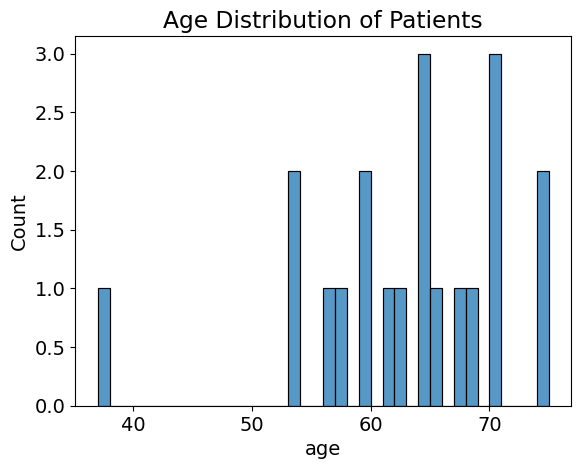

sex
F    11
M     9
Name: count, dtype: int64

subset
train    14
test      6
Name: count, dtype: int64

In [10]:
# Distribution of age, sex and healthcate insurance
patient_columns = ['patient_id', 'protocol', 'sex', 'age', 'diagnosis', 'subset']
patients = objects_df.drop_duplicates(subset="patient_id")[patient_columns]
display(patients)
# age
print("Age statistics")
print(20 * '-')
display(patients['age'].describe())
sns.histplot(data=patients, x='age', binwidth=1)
plt.title('Age Distribution of Patients')
plt.show()
# sex
counts = patients['sex'].value_counts()
display(counts)
# Subset
print('\n')
counts = patients['subset'].value_counts()
display(counts)

In [11]:
# Studies per patients and total studies
grouped = objects_df.groupby(['subset', 'patient_id', 'diagnosis'])['study_uuid'].nunique().reset_index(name="studies_count")
display(grouped)
print(f"total studies: {grouped['studies_count'].sum()}")

,subset,patient_id,diagnosis,studies_count
0,test,3,gallbladder cancer,3
1,test,10,melanoma,1
2,test,15,bladder cancer,3
3,test,28,colon cancer,2
4,test,30,rectal cancer,3
5,test,35,gastric cancer,2
6,train,1,lung cancer,1
7,train,2,gastric cancer,1
8,train,5,colon cancer,1
9,train,7,rectal cancer,3


total studies: 44


In [12]:
# CT images for thorax and abdomen
grouped = objects_df.groupby(['series_region'])['filename'].nunique().reset_index(name="images_count")
display(grouped)

,series_region,images_count
0,Abdomen,32
1,Thorax,21


In [13]:
# Distribution by lesion type (primary, metastases, adenopathy)
grouped = objects_df.groupby('lesion_type').size().reset_index(name='lesions_count')
display(grouped)

,lesion_type,lesions_count
0,m,860
1,n,83
2,t,5


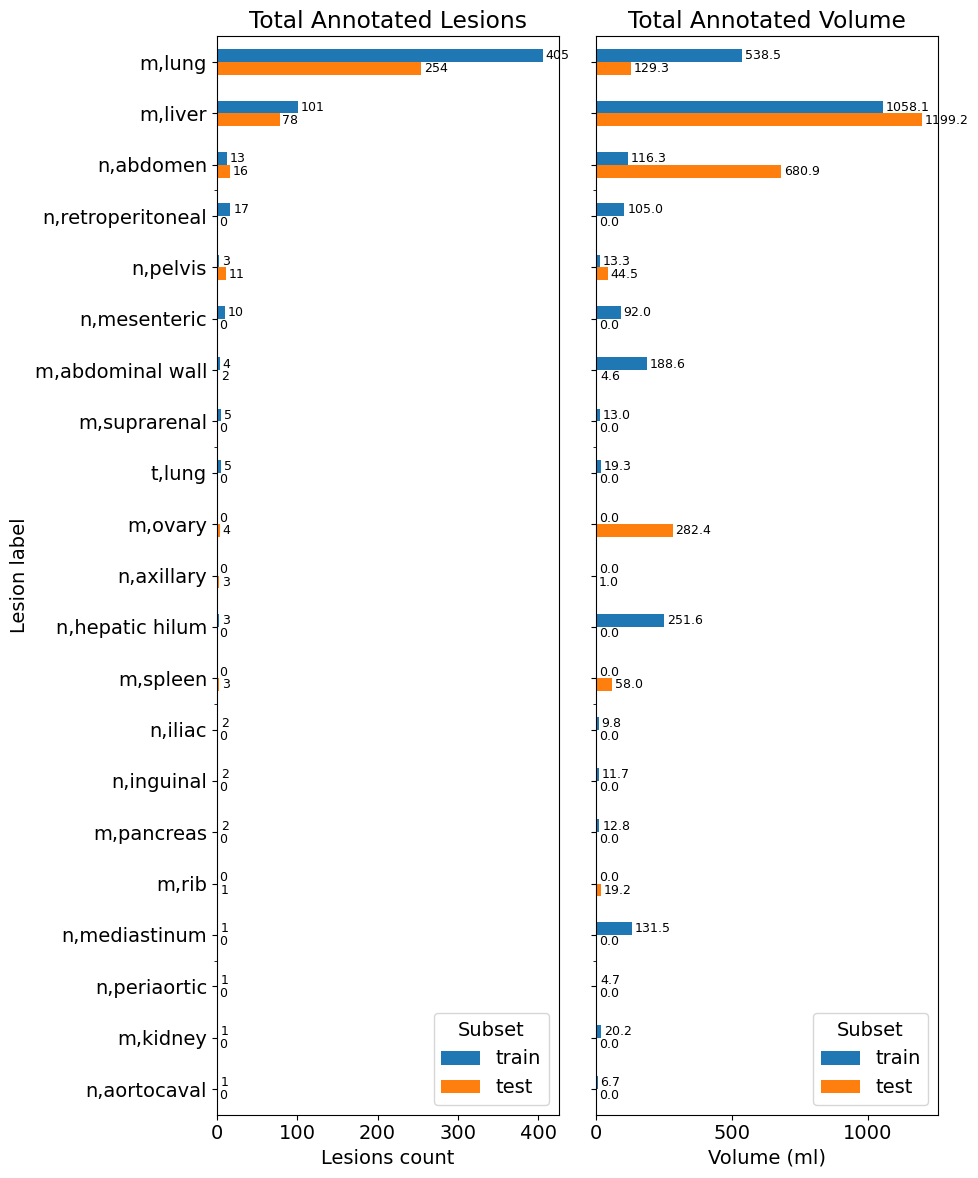

In [14]:
# Horizontal barplots for annotated lesions and annotated volume
_, axes = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(10, 12))
count_grouped = objects_df.groupby(['label_description', 'subset']).size().unstack(fill_value=0)
count_grouped['total'] = count_grouped.sum(axis=1)
count_grouped.sort_values(by='total', inplace=True)
volume_grouped = objects_df.groupby(['label_description', 'subset'])['volume_ml'].sum().unstack(fill_value=0)
volume_grouped['total'] = volume_grouped.sum(axis=1)
for idx, (ax, grouped) in enumerate(zip(axes, [count_grouped, volume_grouped])):
    grouped = grouped.reindex(count_grouped.index)
    grouped[['test', 'train']].plot(
        kind='barh',
        stacked=False,
        color=[plt.cm.tab10.colors[1], plt.cm.tab10.colors[0]],
        ax=ax
    )
    for p in ax.patches:
        left, bottom, width, height = p.get_bbox().bounds
        text = f'{int(width)}' if idx == 0 else f'{width:.1f}'
        ax.annotate(text, xy=(left + width, bottom + height / 2), xytext=(2.0, -0.25), 
                    textcoords='offset points', ha='left', va='center', fontsize=9)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(reversed(handles), reversed(labels), title='Subset', loc='lower right')
axes[0].set_xlabel('Lesions count')
axes[1].set_xlabel('Volume (ml)')
axes[0].set_title('Total Annotated Lesions')
axes[1].set_title('Total Annotated Volume')
axes[0].set_ylabel('Lesion label')
plt.tight_layout()
if savefig:
    plt.savefig(Path.cwd() / 'results' / 'lesions_count_by_label_and_subset_subplots.png', transparent=True)
plt.show()

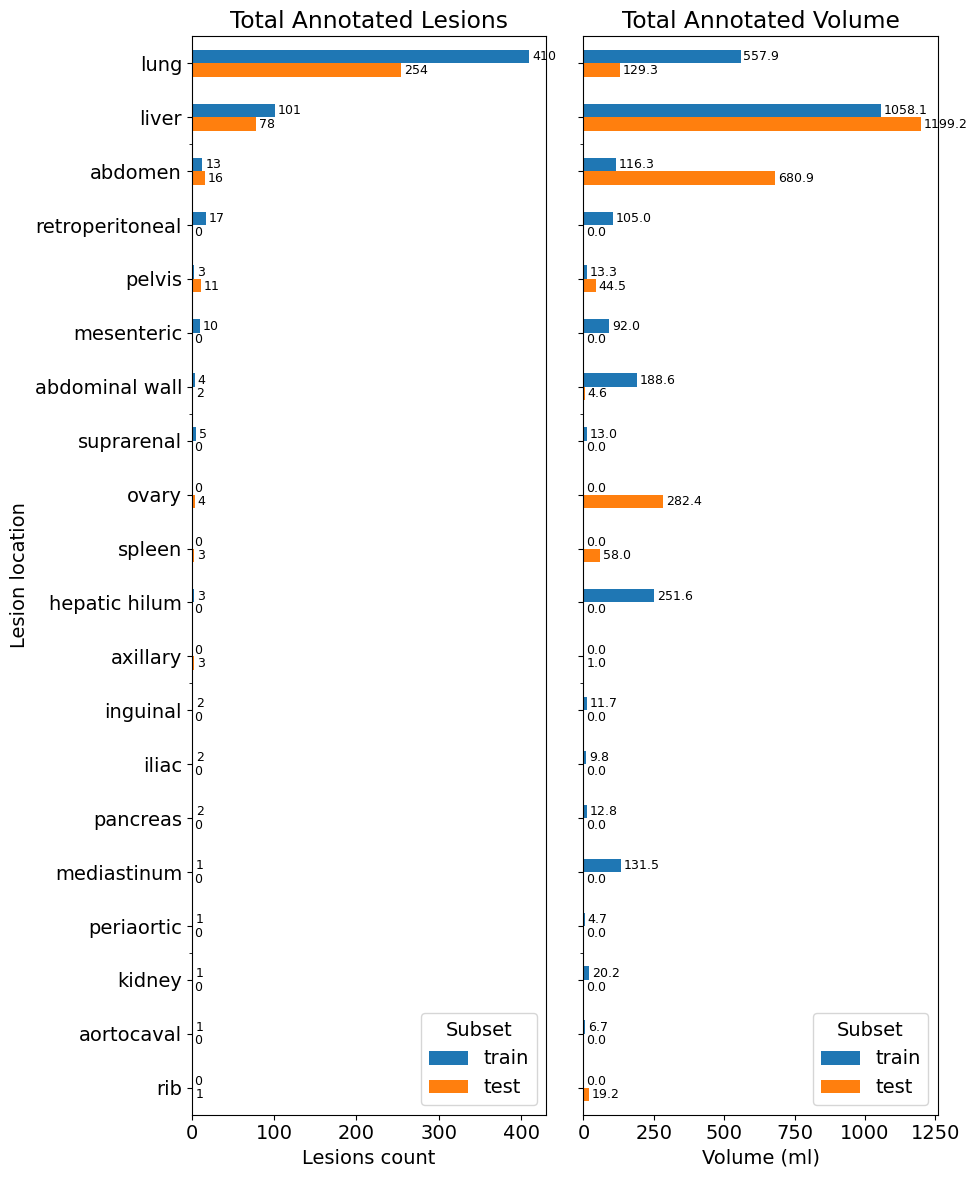

In [15]:
# Horizontal barplots for annotated lesions and annotated volume gruped by lesion location
_, axes = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(10, 12))
count_grouped = objects_df.groupby(['lesion_location', 'subset']).size().unstack(fill_value=0)
count_grouped['total'] = count_grouped.sum(axis=1)
count_grouped.sort_values(by='total', inplace=True)
volume_grouped = objects_df.groupby(['lesion_location', 'subset'])['volume_ml'].sum().unstack(fill_value=0)
volume_grouped['total'] = volume_grouped.sum(axis=1)
for idx, (ax, grouped) in enumerate(zip(axes, [count_grouped, volume_grouped])):
    grouped = grouped.reindex(count_grouped.index)
    grouped[['test', 'train']].plot(
        kind='barh',
        stacked=False,
        color=[plt.cm.tab10.colors[1], plt.cm.tab10.colors[0]],
        ax=ax
    )
    for p in ax.patches:
        left, bottom, width, height = p.get_bbox().bounds
        text = f'{int(width)}' if idx == 0 else f'{width:.1f}'
        ax.annotate(text, xy=(left + width, bottom + height / 2), xytext=(2.0, -0.25), 
                    textcoords='offset points', ha='left', va='center', fontsize=9)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(reversed(handles), reversed(labels), title='Subset', loc='lower right')
axes[0].set_xlabel('Lesions count')
axes[1].set_xlabel('Volume (ml)')
axes[0].set_title('Total Annotated Lesions')
axes[1].set_title('Total Annotated Volume')
axes[0].set_ylabel('Lesion location')
plt.tight_layout()
if savefig:
    plt.savefig(Path.cwd() / 'results' / 'lesions_count_by_location_and_subset_subplots.png', transparent=True)
plt.show()

In [16]:
# Lesions count grouped by patient
patient_columns = ['subset', 'patient_id', 'diagnosis']
grouped = objects_df.groupby(patient_columns).size().reset_index(name="lesions_count")
grouped = grouped.merge(
    objects_df.groupby(patient_columns)['volume_ml'].sum().reset_index(name="annotated_volume_ml"),
    on=patient_columns,
    how='left'
)
display(grouped)

,subset,patient_id,diagnosis,lesions_count,annotated_volume_ml
0,test,3,gallbladder cancer,8,657.519147
1,test,10,melanoma,3,1.047127
2,test,15,bladder cancer,9,26.675090
3,test,28,colon cancer,307,1410.235018
4,test,30,rectal cancer,39,36.760309
5,test,35,gastric cancer,6,287.051530
6,train,1,lung cancer,3,154.148694
7,train,2,gastric cancer,3,13.896270
8,train,5,colon cancer,1,3.153896
9,train,7,rectal cancer,22,130.434613


In [17]:
# Lesions labels for each patient
columns = ['subset', 'patient_id', 'diagnosis', 'label_description']
grouped = objects_df.groupby(columns).size().reset_index(name='lesions_count')
display(grouped)

,subset,patient_id,diagnosis,label_description,lesions_count
0,test,3,gallbladder cancer,"n,abdomen",8
1,test,10,melanoma,"n,axillary",3
2,test,15,bladder cancer,"n,pelvis",9
3,test,28,colon cancer,"m,liver",78
4,test,28,colon cancer,"m,lung",215
5,test,28,colon cancer,"m,rib",1
6,test,28,colon cancer,"m,spleen",3
7,test,28,colon cancer,"n,abdomen",8
8,test,28,colon cancer,"n,pelvis",2
9,test,30,rectal cancer,"m,lung",39


In [18]:
# Patients count for each lesion label
grouped = objects_df.groupby('label_description')['patient_id'].nunique().reset_index(name="patients_count").sort_values(by='patients_count', ascending=False)
display(grouped)

,label_description,patients_count
3,"m,lung",9
2,"m,liver",8
9,"n,abdomen",6
19,"n,retroperitoneal",3
17,"n,pelvis",3
0,"m,abdominal wall",2
8,"m,suprarenal",2
16,"n,mesenteric",2
20,"t,lung",2
7,"m,spleen",1


In [19]:
columns = ['label_description', 'patient_id', 'protocol', 'sex', 'age', 'diagnosis']
grouped = objects_df.drop_duplicates(subset=['label_description', 'patient_id'], ignore_index=True)[columns].sort_values(by='label_description')
display(grouped)
# Sex distribution by sex
grouped = grouped.groupby(['label_description', 'sex']).size().unstack(fill_value=0)
display(grouped)

,label_description,patient_id,protocol,sex,age,diagnosis
16,"m,abdominal wall",35,1029/19,F,53,gastric cancer
36,"m,abdominal wall",25,IE 55/21,F,65,gallbladder cancer
41,"m,kidney",1,IE 55/21,M,70,lung cancer
28,"m,liver",8,IE 55/21,M,59,gastric cancer
27,"m,liver",2,IE 55/21,F,62,gastric cancer
13,"m,liver",5,1029/19,F,59,colon cancer
12,"m,liver",7,1029/19,M,53,rectal cancer
10,"m,liver",28,1029/19,F,37,colon cancer
35,"m,liver",25,IE 55/21,F,65,gallbladder cancer
5,"m,liver",24,1029/19,F,75,gastric cancer


sex,F,M
label_description,,
"m,abdominal wall",2,0
"m,kidney",0,1
"m,liver",5,3
"m,lung",4,5
"m,ovary",1,0
"m,pancreas",0,1
"m,rib",1,0
"m,spleen",1,0
"m,suprarenal",1,1


In [20]:
# Images (series) for each lesion location
grouped = objects_df.groupby('lesion_location')['filename'].nunique().reset_index(name="series_count").sort_values(by='series_count', ascending=False)
display(grouped)

,lesion_location,series_count
9,lung,20
8,liver,18
0,abdomen,12
16,retroperitoneal,6
14,pelvis,5
1,abdominal wall,5
11,mesenteric,4
19,suprarenal,4
4,hepatic hilum,3
12,ovary,2


pixel size stats
------------------------------


count    53.000000
mean      0.665352
std       0.070794
min       0.525391
25%       0.613281
50%       0.671875
75%       0.710938
max       0.828125
Name: row_spacing_mm, dtype: float64

,count,mean,std,min,25%,50%,75%,max
series_region,,,,,,,,
Abdomen,32.0,0.698669,0.059346,0.591797,0.661621,0.702149,0.737793,0.828125
Thorax,21.0,0.614583,0.055581,0.525391,0.580078,0.609375,0.626953,0.740234


slices count stats
------------------------------


count     53.000000
mean     240.584906
std       82.196396
min       97.000000
25%      175.000000
50%      196.000000
75%      324.000000
max      389.000000
Name: slices, dtype: float64

,count,mean,std,min,25%,50%,75%,max
series_region,,,,,,,,
Abdomen,32.0,181.125000,22.403557,97.0,169.25,182.0,195.25,218.0
Thorax,21.0,331.190476,50.116483,150.0,317.00,339.0,359.00,389.0


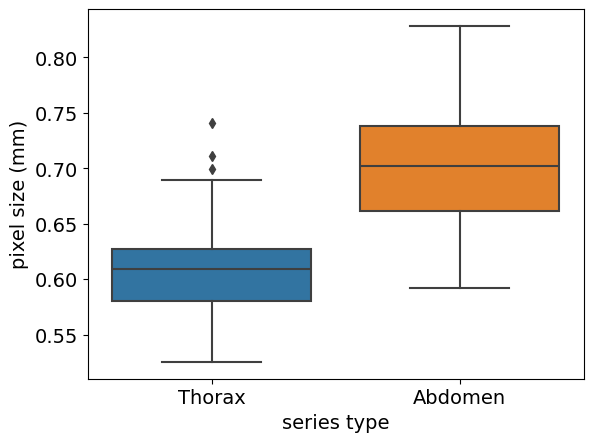

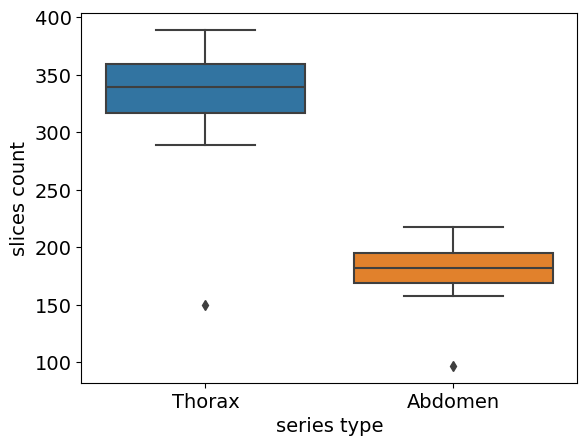

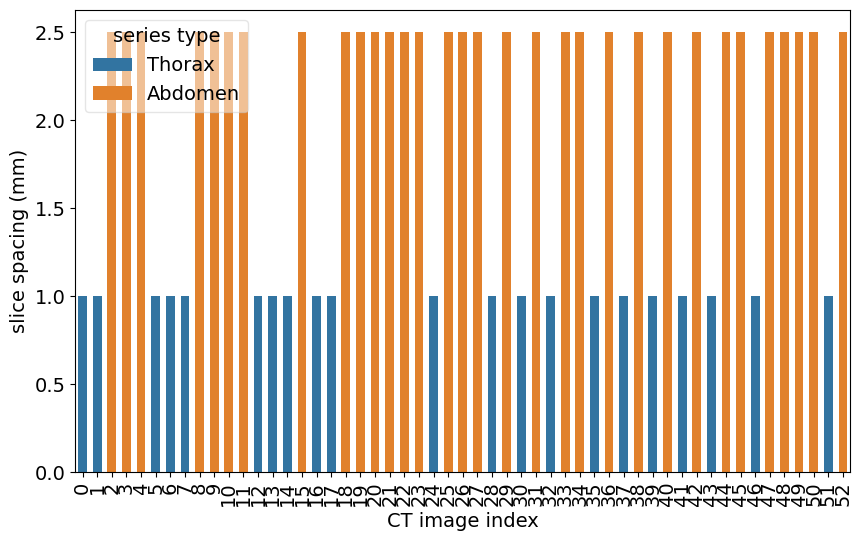

In [21]:
# Resolution information
print("pixel size stats")
print(30 * "-")
display(series_df['row_spacing_mm'].describe())
display(series_df.groupby('series_region')['row_spacing_mm'].describe())
print("slices count stats")
print(30 * "-")
display(series_df['slices'].describe())
display(series_df.groupby('series_region')['slices'].describe())
# Plot pixel spacing
sns.boxplot(
    data=series_df,
    x='series_region',
    y='row_spacing_mm'
)
plt.title('Pixel spacing boxplot')
plt.xlabel('series type')
plt.ylabel('pixel size (mm)')
if savefig:
    if not add_title:
        plt.title('')
    plt.savefig(Path.cwd() / 'results' / 'pixel_spacing_grouped.png', bbox_inches='tight', transparent=True)
plt.show()
# Plot slices count
sns.boxplot(
    data=series_df,
    x='series_region',
    y='slices'
)
plt.title('Slices count boxplot')
plt.xlabel('series type')
plt.ylabel('slices count')
if savefig:
    if not add_title:
        plt.title('')
    plt.savefig(Path.cwd() / 'results' / 'slices_count_grouped.png', bbox_inches='tight', transparent=True)
plt.show()
# Plot Slice Thickness
plt.figure(figsize=(10,6))
sns.barplot(data=series_df, x=series_df.index, y='slice_spacing_mm', hue='series_region', dodge=False, width=0.6)
plt.xticks(rotation=90)
plt.legend(title='series type', framealpha=0.5)
plt.xlabel('CT image index')
plt.ylabel('slice spacing (mm)')
plt.title('Slice spacing for each CT image')
if savefig:
    if not add_title:
        plt.title('')
    plt.savefig(Path.cwd() / 'results' / 'slice_spacing_grouped.png', bbox_inches='tight', transparent=True)
plt.show()

In [22]:
# Image intensity stats
stats_df = pd.DataFrame()
for subset, path in [('train', path_to_image_stats_train), ('test', path_to_image_stats_test)]:
    df = pd.read_csv(path)
    df['subset'] = subset
    stats_df = pd.concat([stats_df, df], ignore_index=True)
stats_df['uuid'] = stats_df["filename"].apply(lambda x: x.split('.nii.gz')[0])
stats_df = stats_df.merge(
    series_df[['uuid', 'series_region']],
    on='uuid',
    how='left'
)
display(stats_df.groupby('series_region').describe())

slices                                                       \
               count        mean        std    min     25%    50%     75%   
series_region                                                               
Abdomen         32.0  181.125000  22.403557   97.0  169.25  182.0  195.25   
Thorax          21.0  331.190476  50.116483  150.0  317.00  339.0  359.00   

                      rows                                                 \
                 max count   mean  std    min    25%    50%    75%    max   
series_region                                                               
Abdomen        218.0  32.0  512.0  0.0  512.0  512.0  512.0  512.0  512.0   
Thorax         389.0  21.0  512.0  0.0  512.0  512.0  512.0  512.0  512.0   

              columns                                                 mean  \
                count   mean  std    min    25%    50%    75%    max count   
series_region                                                                
Abdomen          32.0  512.0  0.0  512.0  512.0  512.0  512.0  512.0  32.0   
Thorax           21.0  512.0  0.0  512.0  512.0  512.0  512.0  512.0  21.0   

                                                                        \
                     mean        std        min         25%        50%   
series_region                                                            
Abdomen       -518.007305  45.388912 -588.15110 -545.405475 -522.28722   
Thorax        -426.202757  55.761631 -556.14246 -469.646420 -423.73970   

                                       std                                    \
                      75%        max count        mean        std        min   
series_region                                                                  
Abdomen       -480.914033 -403.27360  32.0  497.905450   7.378961  480.73492   
Thorax        -394.084140 -316.18167  21.0  501.793507  20.405340  457.44028   

                                                             min               \
                      25%         50%        75%       max count    mean  std   
series_region                                                                   
Abdomen        492.657603  497.230015  501.79211  512.8142  32.0 -1024.0  0.0   
Thorax         488.687040  504.641900  510.77548  537.7687  21.0 -1024.0  0.0   

                                                         Q1              \
                  min     25%     50%     75%     max count        mean   
series_region                                                             
Abdomen       -1024.0 -1024.0 -1024.0 -1024.0 -1024.0  32.0 -994.937500   
Thorax        -1024.0 -1024.0 -1024.0 -1024.0 -1024.0  21.0 -934.714286   

                                                                Q2  \
                     std     min    25%    50%    75%    max count   
series_region                                                        
Abdomen         3.349892 -1001.0 -997.0 -996.0 -993.0 -987.0  32.0   
Thorax         23.084936  -971.0 -949.0 -940.0 -929.0 -866.0  21.0   

                                                                           \
                     mean         std    min    25%    50%     75%    max   
series_region                                                               
Abdomen       -738.187500  277.052625 -942.0 -914.0 -889.0 -615.25 -113.0   
Thorax        -405.047619  275.215275 -893.0 -739.0 -275.0 -194.00 -132.0   

                 Q3                                                     max  \
              count      mean        std   min   25%  50%   75%   max count   
series_region                                                                 
Abdomen        32.0 -8.500000  27.881084 -79.0 -24.5 -4.5  13.0  26.0  32.0   
Thorax         21.0  9.571429  18.214202 -27.0  -1.0  9.0  23.0  47.0  21.0   

                                                                               
                    mean         std     min     25%     50%      75%     max  
seri

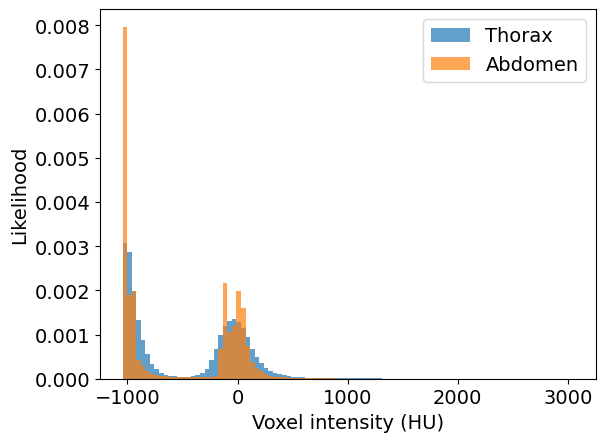

In [23]:
# Distribution (density) of images intensities
densities = {}
for path in [path_to_image_densities_train, path_to_image_densities_test]:
    densities.update(np.load(path, allow_pickle=True).item())
grouped_densities = {"Thorax": [], "Abdomen": []}
series_df.set_index('uuid', inplace=True)
for fname, value in densities.items():
    uuid = fname.split('.nii.gz')[0]
    region = series_df.loc[uuid, 'series_region']
    grouped_densities[region].append({"filename": fname, **value})
series_df.reset_index(inplace=True)
mean_densities = {
    region: {
        "density": np.mean(np.concatenate([subitem["density"].reshape(-1,1) for subitem in item], axis=1), axis=1),
        "bins": item[-1]["bins"]
    }
    for region, item in grouped_densities.items()
}
# Plot
for region in mean_densities.keys():
    plt.bar(
        mean_densities[region]["bins"][:-1],
        mean_densities[region]["density"],
        width=np.diff(mean_densities[region]["bins"]),
        alpha=0.7,
        label=region
    )
plt.xlabel('Voxel intensity (HU)')
plt.ylabel('Likelihood')
plt.title('Distribution of CT images Voxel Intensities')
plt.legend()
if savefig:
    if not add_title:
        plt.title('')
    plt.savefig(Path.cwd() / 'results' / 'voxel_intensities_distribution.png', bbox_inches='tight', transparent=True)
plt.show()